# Unit 5 - Financial Planning

In [ ]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [ ]:
# Load .env enviroment variables
load_dotenv()

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [ ]:
# Set current amount of crypto assets
my_btc = 1.2 
my_eth = 5.3

In [ ]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [ ]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url)
btc_response_content_json = btc_response_data.json()
btc_price = int(btc_response_content_json["data"]["1"]["quotes"]["CAD"]["price"])

# Fetch current ETH price
eth_response_data = requests.get(eth_url)
eth_response_content_json = eth_response_data.json()
eth_price = int(eth_response_content_json["data"]["1027"]["quotes"]["CAD"]["price"])


# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [ ]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [ ]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [ ]:
# Format current date as ISO format
from datetime import datetime
today = datetime.now().isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
bar = api.get_barset(
    tickers, 
    timeframe, 
    start=today, 
    end=today, 
    limit=1000
).df

# Preview DataFrame
bar

In [ ]:
# Pick AGG and SPY close prices
latest_close = bar.tail(1)

agg_close_price = latest_close["AGG"]["close"][0]
spy_close_price = latest_close["SPY"]["close"][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

In [ ]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")

### Savings Health Analysis

In [ ]:
# Set monthly household income
monthly_income = 12000

#investment totals
crypto_total = my_btc_value + my_eth_value
shares_total = my_agg_value + my_spy_value

# Consolidate financial assets data
investment_type = ["crypto ", "shares "]

# Create savings DataFrame
# Create the shares DataFrame with `tickers` as index
df_savings  = pd.DataFrame(index=[investment_type])
df_savings['amount'] = [crypto_total, shares_total]

# Display savings DataFrame
df_savings

In [ ]:
# Plot savings pie chart
labels = 'Crypto', 'Shares'
df_savings.plot.pie(y='amount',subplots=False, autopct='%1.1f%%',labels=labels)

In [ ]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Total Savings
total_savings = df_savings["amount"][0] + df_savings["amount"][1]

# Validate saving health
if total_savings > emergency_fund:
    print(f"Congratulations you have more than enough money in your investments in case of an emergency")
elif total_savings == emergency_fund:
    print(f"Congratulations you have reached your financial goal of having enough money in case of emergency")
elif total_savings < emergency_fund:
    print(f"You are ${(round(total_savings-emergency_fund,2)*-1)} away from having enough money in case of emergency") 

## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [ ]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-12-07', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-12-07', tz='America/New_York').isoformat()

In [ ]:
# Get 5 years' worth of historical data for SPY and AGG

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = api.get_barset(
    tickers, 
    timeframe, 
    start=start_date, 
    end=end_date, limit=1000
).df

# Display sample data
df_stock_data.head()

In [ ]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_40AGG_60SPY_dist = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [ ]:
# Print the simulation input data
MC_40AGG_60SPY_dist.portfolio_data.head()

In [ ]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_40AGG_60SPY_dist.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
MC_40AGG_60SPY_dist.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
MC_40AGG_60SPY_dist.plot_distribution()

### Retirement Analysis

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_40AGG_60SPY_summary = MC_40AGG_60SPY_dist.summarize_cumulative_return()

# Print summary statistics
print(MC_40AGG_60SPY_summary)

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_40AGG_60SPY_summary[8]*initial_investment,2)
ci_upper = round(MC_40AGG_60SPY_summary[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(MC_40AGG_60SPY_summary[8]*initial_investment,2)
ci_upper = round(MC_40AGG_60SPY_summary[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_40AGG_60SPY_dist_5yrs = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_40AGG_60SPY_dist_5yrs.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
MC_40AGG_60SPY_dist_5yrs.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
MC_40AGG_60SPY_dist_5yrs.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_40AGG_60SPY_summary_5yrs = MC_40AGG_60SPY_dist_5yrs.summarize_cumulative_return()

# Print summary statistics
print(MC_40AGG_60SPY_summary_5yrs)

In [ ]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_5yrs = round(MC_40AGG_60SPY_summary_5yrs[8]*initial_investment,2)
ci_upper_5yrs = round(MC_40AGG_60SPY_summary_5yrs[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_5yrs} and ${ci_upper_5yrs}")

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_40AGG_60SPY_dist_10yrs = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_40AGG_60SPY_dist_10yrs.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
MC_40AGG_60SPY_dist_10yrs.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
MC_40AGG_60SPY_dist_10yrs.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_40AGG_60SPY_summary_10yrs = MC_40AGG_60SPY_dist_10yrs.summarize_cumulative_return()

# Print summary statistics
print(MC_40AGG_60SPY_summary_10yrs)

In [ ]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_10yrs = round(MC_40AGG_60SPY_summary_10yrs[8]*initial_investment,2)
ci_upper_10yrs = round(MC_40AGG_60SPY_summary_10yrs[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_10yrs} and ${ci_upper_10yrs}")

### Analyse the Return Ranges

##### There is a 95% chance that an initial investment of 20000 dollars in the portfolio over the next 30 years will end within in the range of 93635.25 and 1401245.17 dollars.

##### There is a 95% chance that an initial investment of 30000 dollars in the portfolio over the next 30 years will end within in the range of 140452.88 and 2101867.75 dollars.

##### There is a 95% chance that an initial investment of 60000 dollars in the portfolio over the next 5 years will end within in the range of 52616.22 and 159946.75 dollars.

##### There is a 95% chance that an initial investment of 60000 dollars in the portfolio over the next 10 years will end within in the range of 73010.25 and 315337.87 dollars.

##### Reducing the investment term to 5 years and increasing the initial investment to 60000 shows that the lower confidence interval reduces to almost 50 percent the 30 year lower ci. The upper confidence level however reduces a massive amount, close to 10 percent of the 30 year upper ci

##### Reducing the investment term to 10 years and increasing the initial investment to 60000 shows that the lower confidence interval reduces to almost 80 percent the 30 year lower ci. The upper confidence level however reduces a massive amount, close to 22 percent of the 30 year upper ci

### Five Years Retirement Option 2

#### Lets see what the figures look like if we use all our savings as an initial investment, and we invest it with a much more aggressive 10/90 bond to shares split for 5 years


In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_40AGG_60SPY_dist_5yrs_Option_2 = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.1,0.9],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_40AGG_60SPY_dist_5yrs_Option_2.calc_cumulative_return()

In [ ]:
# Plot simulation outcomes
MC_40AGG_60SPY_dist_5yrs_Option_2.plot_simulation()

In [ ]:
# Plot probability distribution and confidence intervals
MC_40AGG_60SPY_dist_5yrs_Option_2.plot_distribution()

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_40AGG_60SPY_summary_5yrs_Option_2 = MC_40AGG_60SPY_dist_5yrs_Option_2.summarize_cumulative_return()

# Print summary statistics
print(MC_40AGG_60SPY_summary_5yrs_Option_2)

In [ ]:
# Set initial investment
initial_investment = total_savings

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our total savings
ci_lower_5yrs_Option_2 = round(MC_40AGG_60SPY_summary_5yrs_Option_2[8]*initial_investment,2)
ci_upper_5yrs_Option_2 = round(MC_40AGG_60SPY_summary_5yrs_Option_2[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_5yrs_Option_2} and ${ci_upper_5yrs_Option_2}")

### Ten Years Retirement Option 2

#### Lets see what the figures look like if we use all our savings as an initial investment, and we invest it with a much more aggressive 10/90 bond to shares split for 10 years

In [111]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_40AGG_60SPY_dist_10yrs_Option_2 = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.1,0.9],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [112]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_40AGG_60SPY_dist_10yrs_Option_2.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\AdamF\JLWorkspace\Homework\Week5\Unit-5-Homework-Assignment-Financial-Planning\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993620,0.997637,1.001840,0.987807,1.002236,1.002139,0.995919,0.984978,1.008571,1.002122,...,1.007198,0.987028,1.000214,0.998382,1.005952,1.005805,0.990653,0.996887,0.994113,1.015023
2,0.990182,0.973789,0.989402,0.981403,0.995811,1.004433,0.996784,0.992223,1.009868,1.013830,...,1.003247,1.005593,0.972931,1.003776,1.022323,1.022800,0.972858,1.002813,1.005453,1.025126
3,1.006024,0.968500,0.972616,0.997813,0.999590,0.998628,0.995679,0.991512,1.011453,1.020562,...,1.000844,1.031696,0.954841,1.002533,1.036647,1.020015,0.978618,0.984276,1.032309,1.015397
4,1.000889,0.983409,0.952740,0.989341,0.987328,1.007457,1.018705,0.989343,1.031871,1.031757,...,0.996069,1.061510,0.956184,0.988318,1.035658,1.029804,0.968272,0.980272,1.021153,1.008758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.649730,1.208318,6.615835,3.264903,1.286253,3.345173,0.999473,1.952332,4.405593,1.794537,...,2.124918,1.927189,0.388074,4.035250,0.804642,2.649111,1.756330,10.291784,3.202001,4.029359
2517,1.654761,1.209111,6.613303,3.243057,1.288326,3.328877,0.988866,1.947875,4.488534,1.768311,...,2.069951,1.922803,0.384425,4.016702,0.801494,2.606814,1.722427,10.225545,3.243995,4.021076
2518,1.678435,1.231493,6.675100,3.292411,1.294216,3.370854,1.009078,1.925438,4.398676,1.756385,...,2.102085,1.935311,0.385504,3.990994,0.812862,2.602783,1.686110,10.027062,3.263756,4.114560
2519,1.694585,1.231886,6.660771,3.337636,1.289406,3.302765,1.028731,1.981398,4.333597,1.729045,...,2.106645,1.943381,0.383437,3.942591,0.813291,2.623429,1.693084,9.914971,3.256877,4.152561


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

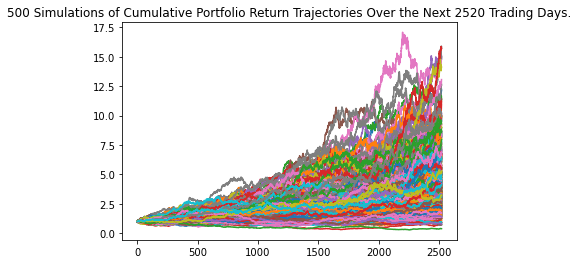

In [113]:
# Plot simulation outcomes
MC_40AGG_60SPY_dist_10yrs_Option_2.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

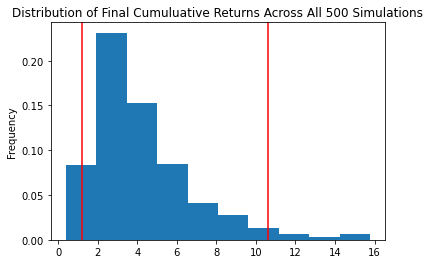

In [114]:
# Plot probability distribution and confidence intervals
MC_40AGG_60SPY_dist_10yrs_Option_2.plot_distribution()

In [115]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_40AGG_60SPY_summary_10yrs_Option_2 = MC_40AGG_60SPY_dist_10yrs_Option_2.summarize_cumulative_return()

# Print summary statistics
print(MC_40AGG_60SPY_summary_10yrs_Option_2)

count           500.000000
mean              4.220750
std               2.551478
min               0.383329
25%               2.470686
50%               3.547216
75%               5.175526
max              15.780005
95% CI Lower      1.201493
95% CI Upper     10.619837
Name: 2520, dtype: float64


In [117]:
# Set initial investment
initial_investment = total_savings

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our total savings
ci_lower_10yrs_Option_2 = round(MC_40AGG_60SPY_summary_10yrs_Option_2[8]*initial_investment,2)
ci_upper_10yrs_Option_2 = round(MC_40AGG_60SPY_summary_10yrs_Option_2[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_10yrs_Option_2} and ${ci_upper_10yrs_Option_2}")

There is a 95% chance that an initial investment of $149351.5 in the portfolio over the next 10 years will end within in the range of $179444.76 and $1586088.53


### Analyse the Return Ranges for option 2

##### There is a 95% chance that an initial investment of 60000 dollars in the portfolio over the next 5 years will end within in the range of 52616.22 and 159946.75 dollars.

##### There is a 95% chance that an initial investment of 60000 dollars in the portfolio over the next 10 years will end within in the range of 73010.25 and 315337.87 dollars.

##### Reducing the investment term to 5 years and increasing the initial investment to 60000 shows that the lower confidence interval reduces to almost 50 percent the 30 year lower ci. The upper confidence level however reduces a massive amount, close to 10 percent of the 30 year upper ci

##### Reducing the investment term to 10 years and increasing the initial investment to 60000 shows that the lower confidence interval reduces to almost 80 percent the 30 year lower ci. The upper confidence level however reduces a massive amount, close to 22 percent of the 30 year upper ci